# Implementing an Sparse Autoencoder

### Model:

\begin{align*}
\boldsymbol{z}_i &= \max(0,V \boldsymbol{x}_i + \boldsymbol{b}) & \text{(layer 1)}\\
\hat{\boldsymbol{x}}_i &= W \boldsymbol{z}_i + \boldsymbol{a} & \text{(layer 2)}
\end{align*}

where $W,V$ are matrices of parameters of the encoder and the decoder, and $\boldsymbol{b},\boldsymbol{a}$ are additional bias parameters. 

### Objective:

\begin{align*}
\min_{W} ~~
\underbrace{ \frac1N \sum_{i=1}^N \| \boldsymbol{x}_i - \hat{\boldsymbol{x}}_i \|^2}_{\text{reconstruction}}
+ \lambda \cdot
\underbrace{\frac1N \sum_{i=1}^N \|\boldsymbol{z}_i\|_1}_{\text{sparsity}}
+ \epsilon \cdot
\underbrace{\sum_{j=1}^h\Big( \frac1N \sum_{i=1}^N [\boldsymbol{z}_i]_j \Big)^{-1}}_{\text{"entropy"}}
+ \eta \cdot \!\!\!\!
\underbrace{\phantom{\Bigg[}\|W\|_F^2 \phantom{\Bigg[}}_{\text{regularization}}
\end{align*}

The objective is composed of four terms: The reconstruction term is the standard mean square error between the data points and their reconstructions. The sparsity term applies a l1-norm to drive activation to zero in the representation. The "entropy" term that ensures that at least a few examples activate each source dimension. The regularization term ensures that the sparsity term remains effective.

In [11]:
# Imports
import numpy as np
import torch
import sklearn,sklearn.datasets
from tqdm import tqdm
from matplotlib import pyplot as plt

(37, 28)


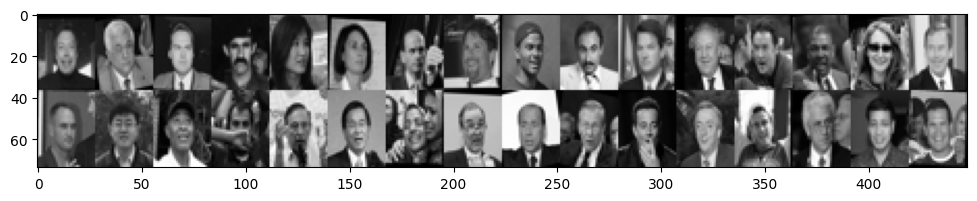

In [2]:
# Get dataset (LFW)
data = sklearn.datasets.fetch_lfw_people(resize=0.3)['images']
print(data[1].shape)

In [ ]:
# Visulize the data
plt.figure(figsize=(12,2.5))
plt.imshow(data[:32].reshape(2,16,37,28).transpose(0,2,1,3).reshape(2*37,16*28),cmap='gray')
plt.show()

In [3]:
# Standardize the data 
X = data.reshape(len(data),-1)
X = X - X.mean(axis=0)
X = X / X.std()

In [5]:
# Data to tensor
X  = torch.FloatTensor(X)

In [6]:
# Get objective terms
def get_objective_terms(X,V,W,b,a):
    Z = torch.maximum(X @ V + b, torch.zeros((X@V).shape))
    X_hat = Z @ W + a
    rec = ((X- X_hat)**2).sum(axis=1).mean()
    spa = Z.sum(axis=1).mean()
    reg = torch.norm(W, p='fro')**2
    ent = (1/Z.mean(axis=0)).sum()
    
    return rec,spa,ent,reg

In [13]:
# Train
def train(X,lambd=0):
    
    d = X.shape[1]
    h = 400
    
    eps = 0.01 * lambd # hard-coded parameter
    eta = 1 * lambd    # hard-coded parameter
    
    V = torch.nn.Parameter(d**-.5*torch.randn([d,h]))
    W = torch.nn.Parameter(torch.zeros([h,d]))
    b = torch.nn.Parameter(torch.zeros([h]))
    a = torch.nn.Parameter(torch.zeros([d]))
    
    optimizer = torch.optim.Adam((V,W,b,a), lr=0.0001)
    
    print('%7s %8s %8s %8s %8s'%('nbit','rec','spa','ent','reg', 'loss'))
    
    for i in tqdm(range(0,10001)):
        
        optimizer.zero_grad()
        
        x = X[np.random.permutation(len(X))[:100]]
        
        rec,spa,ent,reg = get_objective_terms(x,V,W,b,a)
        
        loss = rec + lambd*spa + eps*ent + eta*reg
        loss.backward()

        if i%1000 == 0:
            print('%7s %8s %8s %8s %8s'%('nbit','rec','spa','ent','reg', 'loss'))
            print('%7d %8.2f %8.2f %8.2f %8.2f %8.2f'%(i,rec.data,spa.data,ent.data,reg.data, loss.data))
        
        optimizer.step()

    return V,W,b,a

In [14]:
# Standard autoencoder (no sparsity)
V1,W1,b1,a1 = train(X,lambd=0)

   nbit      rec      spa      ent      reg


  0%|          | 6/10001 [00:00<03:13, 51.61it/s]

      0  1087.44   161.15  1055.62     0.00  1087.44


 10%|█         | 1009/10001 [00:17<02:26, 61.27it/s]

   1000   132.38   425.07   391.38    49.12   132.38


 20%|██        | 2010/10001 [00:32<02:11, 60.73it/s]

   2000    98.69   450.22   370.31    76.94    98.69


 30%|███       | 3013/10001 [00:48<01:53, 61.40it/s]

   3000    85.78   519.96   324.50    97.55    85.78


 40%|████      | 4009/10001 [01:05<01:25, 70.09it/s]

   4000    74.46   521.57   333.11   114.88    74.46


 50%|█████     | 5008/10001 [01:19<01:13, 68.38it/s]

   5000    63.71   597.55   295.12   129.67    63.71


 60%|██████    | 6011/10001 [01:34<00:55, 71.29it/s]

   6000    61.78   607.52   285.63   142.18    61.78


 70%|███████   | 7011/10001 [01:50<00:45, 65.17it/s]

   7000    59.98   697.77   256.13   153.10    59.98


 80%|████████  | 8012/10001 [02:07<00:29, 66.76it/s]

   8000    54.22   747.95   244.03   162.93    54.22


 90%|█████████ | 9015/10001 [02:23<00:13, 71.03it/s]

   9000    54.68   714.39   266.45   171.98    54.68


100%|██████████| 10001/10001 [02:38<00:00, 63.13it/s]

  10000    52.83   831.07   226.48   180.51    52.83


In [15]:
# Sparse Autoencoder
V2,W2,b2,a2 = train(X,lambd=1)

   nbit      rec      spa      ent      reg


  0%|          | 6/10001 [00:00<02:49, 59.01it/s]

      0  1045.31   159.38  1060.63     0.00  1215.29


 10%|█         | 1012/10001 [00:15<02:16, 65.91it/s]

   1000   213.65   177.16  1293.76    77.39   481.13


 20%|██        | 2011/10001 [00:33<02:15, 59.02it/s]

   2000   181.22   159.74  1748.75    76.13   434.57


 30%|███       | 3008/10001 [00:49<01:42, 67.95it/s]

   3000   175.45   155.93  1968.76    73.53   424.61


 40%|████      | 4009/10001 [01:05<01:37, 61.44it/s]

   4000   165.34   152.60  2090.64    71.97   410.81


 50%|█████     | 5012/10001 [01:24<01:16, 65.17it/s]

   5000   163.45   161.29  1959.59    71.18   415.51


 60%|██████    | 6007/10001 [01:43<01:30, 43.89it/s]

   6000   159.92   161.80  2024.09    70.79   412.75


 70%|███████   | 7015/10001 [02:00<00:42, 69.82it/s]

   7000   146.67   153.90  2166.76    70.61   392.85


 80%|████████  | 8007/10001 [02:15<00:27, 72.44it/s]

   8000   141.33   154.84  2160.55    70.53   388.31


 90%|█████████ | 9009/10001 [02:29<00:14, 68.89it/s]

   9000   148.06   156.41  2151.51    70.40   396.37


100%|██████████| 10001/10001 [02:45<00:00, 60.61it/s]

  10000   147.80   162.41  2021.96    70.48   400.92


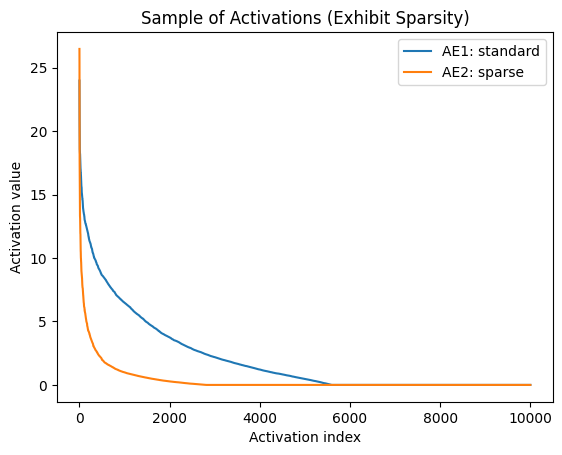

In [21]:
# Check sparsity: Line plot where the two lines represent all activations(for
#  the 25 first examples in the dataset) sorted from largest to smallest of the
# respective autoencoder models.
Z1 = torch.maximum(X @ V1 + b1, torch.zeros((X@V1).shape)).data.numpy()
Z2 = torch.maximum(X @ V2 + b2, torch.zeros((X@V2).shape)).data.numpy()
plt.plot(np.sort(Z1[:25].flatten())[::-1], label = 'AE1: standard')
plt.plot(np.sort(Z2[:25].flatten())[::-1], label = 'AE2: sparse')
plt.xlabel('Activation index')
plt.ylabel('Activation value')
plt.title('Sample of Activations (Exhibit Sparsity)')
plt.legend()
plt.show()

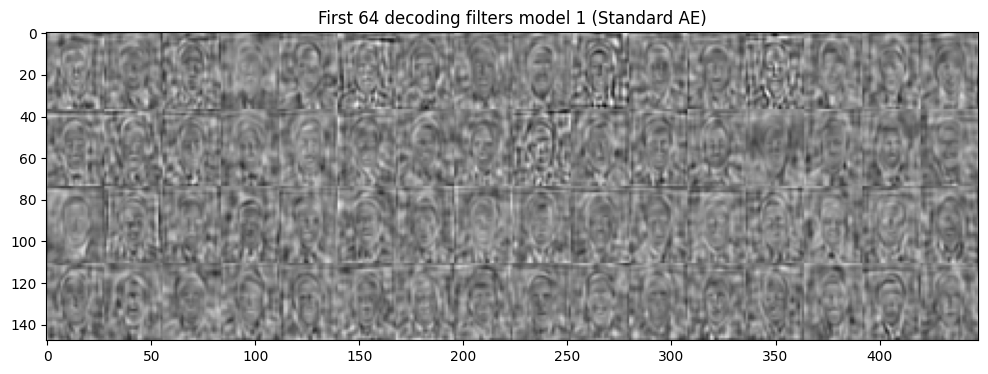

In [31]:
# First 64 decoding filters model 1
plt.figure(figsize=(14,4))
plt.imshow(W1.data.numpy()[:64].reshape(4,16,37,28).transpose(0,2,1,3).reshape(4*37,16*28),cmap='gray')
plt.title('First 64 decoding filters model 1 (Standard AE)')
plt.show()

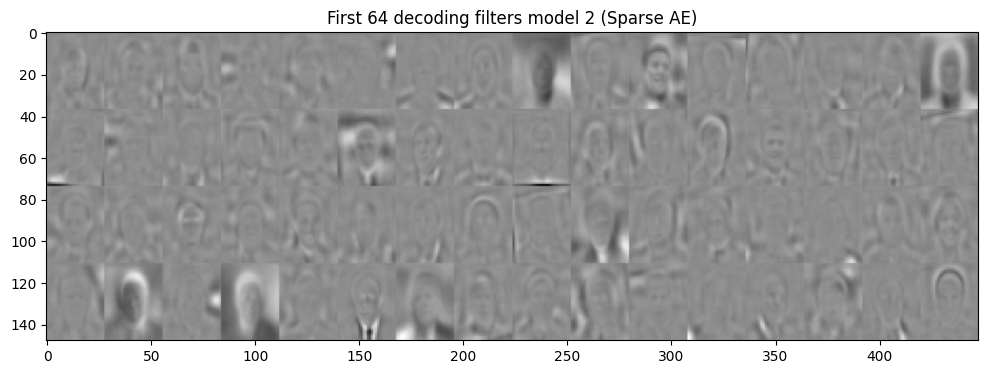

In [30]:
# First 64 decoding filters model 2
plt.figure(figsize=(14,4))
plt.imshow(W2.data.numpy()[:64].reshape(4,16,37,28).transpose(0,2,1,3).reshape(4*37,16*28),cmap='gray')
plt.title('First 64 decoding filters model 2 (Sparse AE)')
plt.show()